# Cifar10 Drift Detection with NVIDIA Triton

In this example we will deploy an image classification model along with a drift detector trained on the same dataset. For in depth details on creating a drift detection model for your own dataset see the [alibi-detect project](https://github.com/SeldonIO/alibi-detect) and associated [documentation](https://docs.seldon.io/projects/alibi-detect/en/latest/). You can find details for this [CIFAR10 example in their documentation](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_ks_cifar10.html) as well.


Prequisites:

 * [Knative eventing installed](https://knative.dev/docs/install/)
     * Ensure the istio-ingressgateway is exposed as a loadbalancer (no auth in this demo)
 * [Seldon Core installed](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/install.html) 
    * Ensure you install for istio, e.g. for the helm chart `--set istio.enabled=true`
 * **A cluster with 2 NVIDIA GPUs available compatible with Triton Inference Server.**
     * Tested with P100 GPUs on GKE (eu-west-1d)
 
 Tested on GKE 1.18 K8S Knative 0.21 and Istio

In [ ]:
!pip install -r requirements_notebook.txt

Ensure gateway installed

In [ ]:
!kubectl apply -f ../../../notebooks/resources/seldon-gateway.yaml

## Setup Resources

In [1]:
!kubectl create namespace cifar10drift

namespace/cifar10drift created


In [31]:
%%writefile broker.yaml
apiVersion: eventing.knative.dev/v1
kind: Broker
metadata:
 name: default
 namespace: cifar10drift

Overwriting broker.yaml


In [3]:
!kubectl apply -f broker.yaml

broker.eventing.knative.dev/default configured


In [4]:
%%writefile event-display.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: hello-display
  namespace: cifar10drift
spec:
  replicas: 1
  selector:
    matchLabels: &labels
      app: hello-display
  template:
    metadata:
      labels: *labels
    spec:
      containers:
        - name: event-display
          image: gcr.io/knative-releases/knative.dev/eventing-contrib/cmd/event_display

---

kind: Service
apiVersion: v1
metadata:
  name: hello-display
  namespace: cifar10drift
spec:
  selector:
    app: hello-display
  ports:
  - protocol: TCP
    port: 80
    targetPort: 8080

Overwriting event-display.yaml


In [5]:
!kubectl apply -f event-display.yaml

deployment.apps/hello-display unchanged
service/hello-display unchanged


Create the SeldonDeployment image classification model for Cifar10. We add in a `logger` for requests - the default destination is the namespace Knative Broker.

In [6]:
%%writefile cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: triton-cifar10
  namespace: cifar10drift
spec:
  predictors:
  - componentSpecs:
    - metadata: {}
      spec:
        containers:
        - image: nvcr.io/nvidia/tritonserver:20.08-py3
          name: cifar10
          resources:
            limits:
              cpu: "1"
              memory: 20Gi
              nvidia.com/gpu: "1"
            requests:
              cpu: "1"
              memory: 10Gi
              nvidia.com/gpu: "1"
    graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
        url: http://broker-ingress.knative-eventing.svc.cluster.local/cifar10drift/default            
      modelUri: gs://seldon-models/triton/tf_cifar10
      name: cifar10
      type: MODEL
    name: default
    replicas: 1
  protocol: kfserving

Overwriting cifar10.yaml


In [7]:
!kubectl apply -f cifar10.yaml

seldondeployment.machinelearning.seldon.io/triton-cifar10 unchanged


Create the pretrained Drift Detector. We forward replies to the message-dumper we started. Notice the `drift_batch_size`. The drift detector will wait until `drify_batch_size` number of requests are received before making a drift prediction.

In [30]:
%%writefile cifar10cd.yaml
apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: drift-detector
  namespace: cifar10drift
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: seldonio/alibi-detect-server-gpu:1.7.0-dev
        imagePullPolicy: Always
        args:
        - --model_name
        - cifar10cd
        - --http_port
        - '8080'
        - --protocol
        - kfserving.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/cd/mmd/cifar10_mmd_torch
        - --reply_url
        - http://hello-display.cifar10drift
        - --event_type
        - io.seldon.serving.inference.drift
        - --event_source
        - io.seldon.serving.cifar10cd
        - DriftDetector
        - --drift_batch_size
        - '5000'
        resources:
          limits:
            cpu: "1"
            memory: 20Gi
            nvidia.com/gpu: "1"
          requests:
            cpu: "1"
            memory: 10Gi
            nvidia.com/gpu: "1"


Overwriting cifar10cd.yaml


In [9]:
!kubectl apply -f cifar10cd.yaml

service.serving.knative.dev/drift-detector configured


Create a Knative trigger to forward logging events to our Outlier Detector.

In [10]:
%%writefile trigger.yaml
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: drift-trigger
  namespace: cifar10drift
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: drift-detector
      namespace: cifar10drift


Overwriting trigger.yaml


In [11]:
!kubectl apply -f trigger.yaml

trigger.eventing.knative.dev/drift-trigger unchanged


Get the IP address of the Istio Ingress Gateway. This assumes you have installed istio with a LoadBalancer.

In [32]:
CLUSTER_IPS = !(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP = CLUSTER_IPS[0]
print(CLUSTER_IP)

104.155.57.161


If you are using Kind or Minikube you will need to port-forward to the istio ingressgateway and uncomment the following

In [33]:
# CLUSTER_IP="localhost:8004"

Optionally add an authorization token here if you need one.Acquiring this token will be dependent on your auth setup.

In [34]:
TOKEN = "Bearer <token>"

In [35]:
SERVICE_HOSTNAMES = !(kubectl get ksvc -n cifar10drift drift-detector -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_CD = SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_CD)

drift-detector.cifar10drift.example.com


In [36]:
import json

import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf

tf.keras.backend.clear_session()

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis("off")
    plt.show()


def predict(X):
    formData = {
        "inputs": [
            {
                "name": "input_1",
                "datatype": "FP32",
                "shape": [X.shape[0], 32, 32, 3],
                "data": X.flatten().tolist(),
            }
        ]
    }
    headers = {
        "Authorization": "Bearer " + TOKEN,
        "X-Auth-Token": TOKEN,
        "Content-Type": "application/json",
    }
    res = requests.post(
        "http://"
        + CLUSTER_IP
        + "/seldon/cifar10drift/triton-cifar10/v2/models/cifar10/infer",
        json=formData,
        headers=headers,
    )
    if res.status_code == 200:
        j = res.json()
        y = np.array(j["outputs"][0]["data"])
        y.shape = tuple(j["outputs"][0]["shape"])
        return [classes[x.argmax()] for x in y]
    else:
        print("Failed with ", res.status_code)
        return []


def drift(X):
    formData = {
        "inputs": [
            {
                "name": "input_1",
                "datatype": "FP32",
                "shape": [1, 32, 32, 3],
                "data": X.flatten().tolist(),
            }
        ]
    }
    headers = {}
    headers = {
        "ce-namespace": "default",
        "ce-modelid": "cifar10drift",
        "ce-type": "io.seldon.serving.inference.request",
        "ce-id": "1234",
        "ce-source": "localhost",
        "ce-specversion": "1.0",
    }
    headers["Host"] = SERVICE_HOSTNAME_CD
    headers["X-Auth-Token"] = TOKEN
    headers["Authorization"] = "Bearer " + TOKEN
    res = requests.post("http://" + CLUSTER_IP + "/", json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        return od
    else:
        print("Failed with ", res.status_code)
        return []

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Normal Prediction

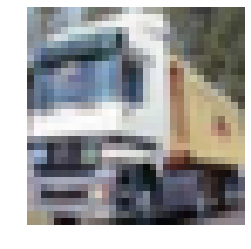

['truck']

In [37]:
idx = 1
X = X_train[idx : idx + 1]
show(X)
predict(X)

## Test Drift

We need to accumulate a large enough batch size so no drift will be tested as yet.

We will now send 5000 requests to the model in batches. The drift detector will run at the end of this as we set the `drift_batch_size` to 5000 in our yaml above.

In [40]:
from tqdm.notebook import tqdm

for i in tqdm(range(1, 5000, 500)):
    X = X_train[i : i + 500]
    predict(X)

  0%|          | 0/10 [00:00<?, ?it/s]

Let's check the message dumper and extract the first drift result.

In [41]:
res = !kubectl logs -n cifar10drift $(kubectl get pod -n cifar10drift -l app=hello-display -o jsonpath='{.items[0].metadata.name}')
data = []
for i in range(0, len(res)):
    if res[i] == "Data,":
        data.append(res[i + 1])
j = json.loads(json.loads(data[0]))
print("Drift", j["data"]["is_drift"] == 1)

Drift False


Now, let's create some CIFAR10 examples with motion blur.

In [42]:
from alibi_detect.datasets import corruption_types_cifar10c, fetch_cifar10c

corruption = ["motion_blur"]
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype("float32") / 255

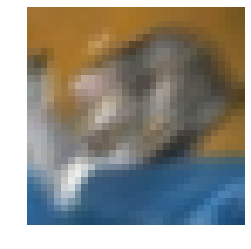

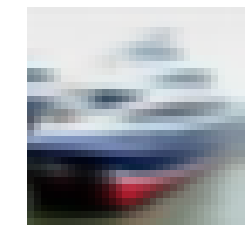

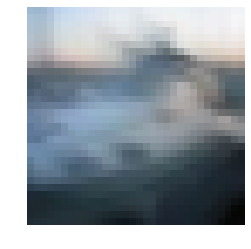

In [43]:
show(X_corr[0])
show(X_corr[1])
show(X_corr[2])

Send these examples to the predictor.

In [44]:
from tqdm.notebook import tqdm

for i in tqdm(range(0, 5000, 500)):
    X = X_corr[i : i + 500]
    predict(X)

  0%|          | 0/10 [00:00<?, ?it/s]

Now when we check the message dump we should find a new drift response.

In [45]:
res = !kubectl logs -n cifar10drift $(kubectl get pod -n cifar10drift -l app=hello-display -o jsonpath='{.items[0].metadata.name}')
data = []
for i in range(0, len(res)):
    if res[i] == "Data,":
        data.append(res[i + 1])
j = json.loads(json.loads(data[-1]))
print("Drift", j["data"]["is_drift"] == 1)

Drift True


## Tear Down

In [ ]:
!kubectl delete ns cifar10drift